In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load data
data_H = pd.read_excel("../Data/Human Voluntary Data.xlsx", sheet_name='Dynamics')
data_M = pd.read_excel("../Data/Murine Data.xlsx")
data_H[['Error Metric', 'Error Value']] = data_H[['Error Metric', 'Error Value']].replace({'None': np.nan}) 
# Drop Error Metric and Error Value columns
data_H = data_H.drop(columns=['Error Metric', 'Error Value'])

# Define a function to remove data based on an input string or list of strings and column name
def rmdata(data, string, col):
    for i in string:
        data = data[data[col] != i]
    return data

print('Database contains ', data_H['State'].unique()) #find and print unique states 

filter = ['NaN'] # Drop missing data
data_H = rmdata(data_H, filter, 'State')
print('Dropped', len(filter), 'states. ', data_H['State'].unique(), 'remain.')

filter = ['NaN', 'Serum'] # Drop Serum measurements
data_H = rmdata(data_H, filter, 'Sample')

filter = ['Night'] # PM measurements 
data_H = rmdata(data_H, filter, 'Condition')

filter = ['B'] # Remove data from b-type flu
data_H = rmdata(data_H, filter, 'Influenza')

references = data_H['Source'].unique() # get unique references (Souce)
print('Database contains ', references.shape[0], 'unique references:')
for i in references:
    print(i, end=', ' if i!=references[-1] else '\n')

states = data_H['State'].unique()
pairs = []

for i in states:
    for j in references:
        if data_H[(data_H['State'] == i) & (data_H['Source'] == j)].shape[0] > 0:
            pairs.append((i,j))
            
print('Database contains', len(pairs), 'unique, extant state/sample pairs.')
for i in pairs:
    print(i[0], i[1], end=', ' if i!=pairs[-1] else '\n')
    
n_plot = len(data_H['State'].unique())
palette = sns.color_palette("husl", len(references))
marker_palette = ['o', 'v', 's', 'p', 'P', 'X', 'D', 'd']
t_plot = [0, 12]

# Define function to calculate weighted mean and standard deviation
def calculate_weighted_stats(data, groupby_cols, val_col, weight_col):
    weighted_avg = data.groupby(groupby_cols).apply(
        lambda x: np.average(x[val_col], weights=x[weight_col]) if len(x[val_col]) > 1 else x[val_col].values[0]
    ).reset_index().rename(columns={0: f'Weighted_{val_col}'})
    
    weighted_std = data.groupby(groupby_cols).apply(
        lambda x: np.sqrt(np.average((x[val_col]-x[val_col].mean())**2, weights=x[weight_col])) if len(x[val_col]) > 1 else 0
    ).reset_index().rename(columns={0: f'Weighted_Std_{val_col}'})
    return pd.merge(weighted_avg, weighted_std, on=groupby_cols)

# Calculate weighted mean/std for human and M data
human = calculate_weighted_stats(data_H, ['State', 'Time'], 'LogVal', 'Patients')
M_melted = data_M.melt(id_vars=['Time', 'SampleID'], var_name='State', value_name='LogVal')
M = calculate_weighted_stats(M_melted, ['State', 'Time'], 'LogVal', 'SampleID')

# Create a directory for the plots if it doesn't exist
output_dir = "../Figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


Database contains  ['V' 'vRNA' 'MIP1a' 'MIP1b' 'MCP1' 'RANTES' 'IL6' 'TNFA' 'IFNG' 'IL10'
 'IFNA' 'IL8' 'GCSF']
Dropped 1 states.  ['V' 'vRNA' 'MIP1a' 'MIP1b' 'MCP1' 'RANTES' 'IL6' 'TNFA' 'IFNG' 'IL10'
 'IFNA' 'IL8' 'GCSF'] remain.
Database contains  11 unique references:
Barroso (2005), Memoli (2016), Calfee (1999), Fritz(1999), Hayden (1998), Hayden (1994), Memoli (2015), Hayden (1999), Skoner(1999), Wilkinson (2012), Oshansky (2014)
Database contains 24 unique, extant state/sample pairs.
V Barroso (2005), V Calfee (1999), V Fritz(1999), V Hayden (1998), V Hayden (1994), V Hayden (1999), V Wilkinson (2012), vRNA Memoli (2016), vRNA Memoli (2015), vRNA Oshansky (2014), MIP1a Fritz(1999), MIP1b Fritz(1999), MCP1 Fritz(1999), RANTES Fritz(1999), IL6 Fritz(1999), IL6 Hayden (1998), IL6 Skoner(1999), TNFA Fritz(1999), TNFA Hayden (1998), IFNG Fritz(1999), IL10 Fritz(1999), IFNA Hayden (1998), IL8 Hayden (1998), IL8 Skoner(1999)


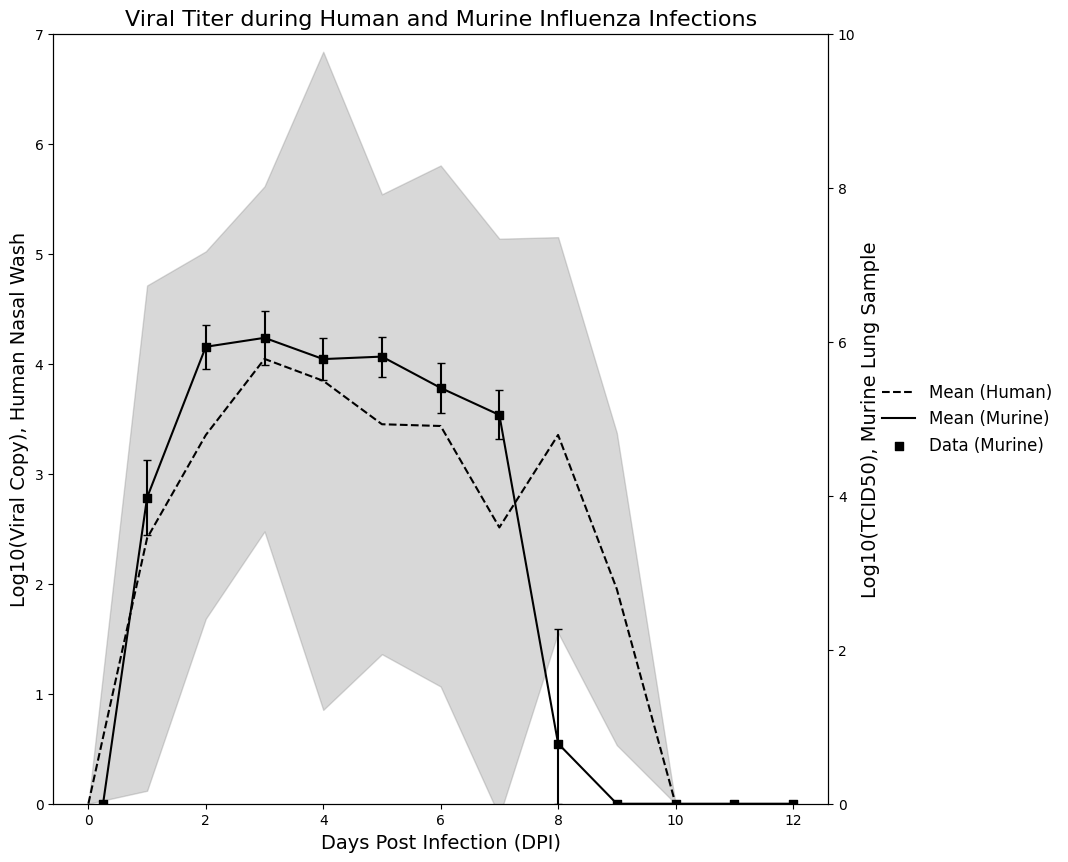

In [8]:
# State (string), ylim(min), ylim(max) for M axes
M_ylims = {'V': (0.0, 10.0), 'vRNA': (0.0, 10.0), 'IL6': (1.0, 3.5), 'IFNG': (1.0, 5.0), 'MCP1': (1.0, 4.0), 'TNFA': (0.5, 2.0), 'IFNA': (0.0, 3.5), 'IL10': (0.5, 3.5), 'MIP1a': (0.0, 3.0), 'MIP1b': (0.0, 3.0), 'RANTES': (0.5, 3.0)} 
H_ylims = {'V': (0.0, 5.0), 'vRNA': (0.0, 7.0), 'IL6': (0.0, 2.5), 'IFNG': (0.0, 2.0), 'MCP1': (0.0, 2.5), 'TNFA': (0.0, 3.0), 'IFNA': (0.0, 2.5), 'IL10': (0.0, 2.0), 'MIP1a': (0.0, 3.0), 'MIP1b': (0.0, 3.0), 'RANTES': (1.5, 2.5)}

states = human['State'].unique()
states = ['vRNA']
for state in states:
    if state not in M['State'].values and state != 'vRNA':
        continue
    if state == 'vRNA':
        M_state = 'V'
        
    plt.figure(figsize=(10, 10))
    ax = plt.gca() 
    ax2 = ax.twinx()
    for source in data_H['Source'].unique():
        source_data = data_H[(data_H['State'] == state) & (data_H['Source'] == source)]
        
        if not source_data.empty:
            color = palette[list(data_H['Source'].unique()).index(source)]
            strains = source_data['HN'].unique() # Check if multiple HN values exist for the same source (multiple A type flus)
            strain_count = len(strains)
            if strain_count > 1:    # Plot each strain with a unique symbol, filled with the color of the study
                for i, strain in enumerate(strains):
                    strain_data = source_data[source_data['HN'] == strain]
                    #sns.scatterplot(data=strain_data, x='Time', y='LogVal', marker=marker_palette[i],  ax=ax, color=color, label=f'{source} (Human, {strain})', s=100, legend=False)
            else:
                strain = strains[0]
                #sns.scatterplot(data=source_data, x='Time', y='LogVal', ax=ax, color=color, label=f'{source} (Human, {strain})', s=100, legend=False)
            #sns.lineplot(data=source_data, x='Time', y='LogVal', ax=ax, color=color, linestyle='--', alpha=0.5, legend=False, errorbar=None)
    ax.set_ylim(H_ylims[state])

    # Plot weighted average for human data
    human_state_data = human[human['State'] == state]
    if state == 'V': # Add additional data points at time = 0 and time = 9 with V = 0 and 0 variance
        additional_data = pd.DataFrame({'State': [state, state], 'Time': [0, 9], 'Weighted_LogVal': [0, 0], 'Weighted_Std_LogVal': [0, 0]})
        human_state_data = pd.concat([human_state_data, additional_data])
        human_state_data = human_state_data.sort_values(by=['Time'])
        
    if state == 'vRNA': # Add additional data points at time = 0 with vRNA = 0 and 0 variance
        additional_data = pd.DataFrame({'State': [state], 'Time': [0], 'Weighted_LogVal': [0], 'Weighted_Std_LogVal': [0]})
        human_state_data = pd.concat([human_state_data, additional_data])
        human_state_data = human_state_data.sort_values(by=['Time'])
        
    ax.plot(human_state_data['Time'], human_state_data['Weighted_LogVal'], '--', color='black', label='Mean (Human)')
    ax.fill_between(human_state_data['Time'], human_state_data['Weighted_LogVal'] - 2 * human_state_data['Weighted_Std_LogVal'], human_state_data['Weighted_LogVal'] + 2 * human_state_data['Weighted_Std_LogVal'], color='grey', alpha=0.3)

    M_state_data = M[M['State'] == M_state]

    M_state_data.loc[M_state_data['Time'] == 0, 'Time'] = 0.25
    sns.lineplot(data=M_state_data, x='Time', y='Weighted_LogVal', ax=ax2, color='black', linestyle='solid', label='Mean (Murine)')
    ax2.scatter(M_state_data['Time'], M_state_data['Weighted_LogVal'], marker='s', color='black', label='Data (Murine)')
    for index, row in M_state_data.iterrows():
        mean_log_val = row['Weighted_LogVal']
        std_dev = row['Weighted_Std_LogVal']
        lower_error_log = mean_log_val - std_dev
        lower_error_log = max(lower_error_log, 0)
        upper_error_log = std_dev
        ax2.errorbar(row['Time'], mean_log_val, yerr=[[mean_log_val - lower_error_log], [upper_error_log]], fmt='none', ecolor='black', capsize=3)
    ax2.set_ylim(M_ylims[state])

    ax.set_xlabel('Days Post Infection (DPI)', fontsize=14)
    
    if state == 'V':
        ax.set_ylabel(f'Log10(TCID50), Human Nasal Wash', fontsize=14)
        ax2.set_ylabel(f'Log10(TCID50), Murine Lung Sample', fontsize=14)
        plt.title(f'Viral Titer during Human and Murine Influenza Infections', fontsize=16)
    elif state == 'vRNA':
        ax.set_ylabel(f'Log10(Viral Copy), Human Nasal Wash', fontsize=14)
        ax2.set_ylabel(f'Log10(TCID50), Murine Lung Sample', fontsize=14)
        plt.title(f'Viral Titer during Human and Murine Influenza Infections', fontsize=16)
    else:
        ax.set_ylabel(f'Log10({state}), Human Nasal Wash', fontsize=14)
        ax2.set_ylabel(f'Log10({state}), Murine Lung Sample', fontsize=14)
        plt.title(f'{state} during Human and Murine Influenza Infections', fontsize=16)

    handles, labels = [], []
    for ax in [ax, ax2]:
        for h, l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    ax2.legend(handles, labels, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, fontsize=12)

    filename = f"{state}_plot.svg".replace(' ', '_').replace('(', '').replace(')', '')
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='svg', bbox_inches='tight')
    plt.show()
    plt.close()